# Titanic pipeline

https://towardsdatascience.com/are-you-using-pipeline-in-scikit-learn-ac4cd85cb27f

If you are doing Machine Learning, you would have come across pipelines as they help you to make a better machine learning workflow which is easy to understand and reproducible.

I recently discovered that you can combine Pipeline with GridSearchCV to not only find best hyperparameters for your model but can also find the best transformers for your machine learning tasks like-

* Scaler to scale your data.
* Impute strategy to fill missing values.
* The number of components in PCA you should use.

and many others. Let’s see how it can be done.

## Dataset details

To best demonstrate, I am going to use the Titanic dataset from OpenML here to walkthrough on how you can create a data pipeline.

You can download the dataset using the following commands-

In [1]:
from sklearn.datasets import fetch_openml
# Dataset details at- https://www.openml.org/d/40945
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
df = X.join(y)

In [2]:
X.shape

(1309, 13)

In [3]:
X.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
y.shape

(1309,)

In [5]:
y.head()

0    1
1    1
2    0
3    0
4    0
Name: survived, dtype: category
Categories (2, object): ['0', '1']

<AxesSubplot:>

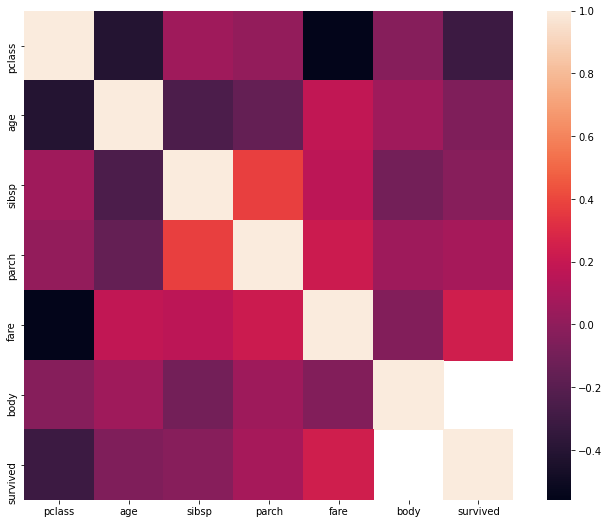

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import to_numeric

df['survived'] = to_numeric(df.survived)
plt.subplots(figsize=(12,9))
sns.heatmap(df.corr(), vmax=1.0, square=True)

# Creating Data Transformer Pipeline

I am going to use a subset of features for the demo purposes here. The dataset has both categorical and numerical features and we would be applying different operations on them. Here is the flow-

1. Define numerical and categorical features.

In [7]:
# numerical features from the dataset
numerical_features = ['age', 'fare']

# categorical features from the dataset
categorical_features = ['embarked', 'sex', 'pclass']

In [8]:
# Split arrays or matrices into random train and test subsets.
#
# Quick utility that wraps input validation and next(ShuffleSplit().split(X, y)) and application to input 
# data into a single call for splitting (and optionally subsampling) data in a oneliner.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [9]:
# Pipeline of transforms with a final estimator.
#
# Sequentially apply a list of transforms and a final estimator. Intermediate steps of the pipeline 
# must be ‘transforms’, that is, they must implement fit and transform methods. The final estimator 
# only needs to implement fit. The transformers in the pipeline can be cached using memory argument.
#
# The purpose of the pipeline is to assemble several steps that can be cross-validated together while 
# setting different parameters. For this, it enables setting parameters of the various steps using their 
# names and the parameter name separated by a ‘__’, as in the example below. A step’s estimator may be 
# replaced entirely by setting the parameter with its name to another estimator, or a transformer removed 
# by setting it to ‘passthrough’ or None.
from sklearn.pipeline import Pipeline

2. For numerical features, fill the missing values and then scale the data.

The numerical features in the dataset have few missing values and we are using SimpleImputer here to fill these values, other imputers can be used as well. Also, we should standardize the range of numerical features using Scaling as many machine learning models require features that follow the same scale. I have not defined the strategy for imputing and the scaler need to be used as the same can be searched using GridSearchCV.

In [10]:
# Imputation transformer for completing missing values.
from sklearn.impute import SimpleImputer

# Applying SimpleImputer and will search for different scalers using GridSearchCV
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', 'passthrough')])

3. For categorical features, fill the missing values and then apply one-hot encoding.

The ‘Embarked’ feature in our dataset has few missing values. The reason to create a different imputer for this as we have different strategies to fill categorical features. Also, as categorical features have only a few values, I am using OneHotEncoder which is commonly used to create different features for each value in categorical columns. The strategy of imputing is searched using GridSearchCV.

In [11]:
# Encode categorical features as a one-hot numeric array.
#
# The input to this transformer should be an array-like of integers or strings, denoting the values taken 
# on by categorical (discrete) features. The features are encoded using a one-hot (aka ‘one-of-K’ or ‘dummy’) 
# encoding scheme. This creates a binary column for each category and returns a sparse matrix or dense array 
# (depending on the sparse parameter).
#
# By default, the encoder derives the categories based on the unique values in each feature. Alternatively, 
# you can also specify the categories manually.
# This encoding is needed for feeding categorical data to many scikit-learn estimators, notably linear models 
# and SVMs with the standard kernels.
#
# Note: a one-hot encoding of y labels should use a LabelBinarizer instead.
from sklearn.preprocessing import OneHotEncoder

# Applying SimpleImputer and then OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

## Combine numerical and categorical transformer using ColumnTransformer.

ColumnTransformer helps to define different transformers for different types of inputs and combine them into a single feature space after transformation. Here we are applying numerical transformer and categorical transformer created above for our numerical and categorical features.

In [12]:
# Applies transformers to columns of an array or pandas DataFrame.
#
# This estimator allows different columns or column subsets of the input to be transformed separately and 
# the features generated by each transformer will be concatenated to form a single feature space. This is 
# useful for heterogeneous or columnar data, to combine several feature extraction mechanisms or 
# transformations into a single transformer.
from sklearn.compose import ColumnTransformer

data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)])

## Apply PCA to reduce dimensions.

Principle Component Analysis aka PCA is a linear dimensionality reduction algorithm that is used to reduce the number of features in the dataset by keeping the maximum variance. We might not need to apply PCA here as it is a small dataset but the idea is to show how you can search for number_of _components in PCA using GridSearchCV.

In [13]:
# Principal component analysis (PCA).
#
# Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower 
# dimensional space. The input data is centered but not scaled for each feature before applying the SVD.
#
# It uses the LAPACK implementation of the full SVD or a randomized truncated SVD by the method of 
# Halko et al. 2009, depending on the shape of the input data and the number of components to extract.
#
# It can also use the scipy.sparse.linalg ARPACK implementation of the truncated SVD.
#
# Notice that this class does not support sparse input. See TruncatedSVD for an alternative with sparse data.
from sklearn.decomposition import PCA

# Creating preprocessor pipeline which will first transform the data
# and then apply PCA.
preprocessor = Pipeline(steps=[('data_transformer', data_transformer),
                             ('reduce_dim',PCA())])

## Adding Classifier to the Pipeline

Above, we created a preprocessor pipeline with all the operations we would like to apply to our data. I am going to use Logistic Regression here as a classifier for our problem. In case you are interested to know how you can apply multiple models, Rebecca Vickery has mentioned a nice way of doing it in her blog.

In [14]:
# Logistic Regression (aka logit, MaxEnt) classifier.
#
# In the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the ‘multi_class’ option
# is set to ‘ovr’, and uses the cross-entropy loss if the ‘multi_class’ option is set to ‘multinomial’. 
# (Currently the ‘multinomial’ option is supported only by the ‘lbfgs’, ‘sag’, ‘saga’ and ‘newton-cg’ solvers.)
#
# This class implements regularized logistic regression using the ‘liblinear’ library, ‘newton-cg’, ‘sag’, 
# ‘saga’ and ‘lbfgs’ solvers. Note that regularization is applied by default. It can handle both dense and 
# sparse input. Use C-ordered arrays or CSR matrices containing 64-bit floats for optimal performance; any 
# other input format will be converted (and copied).
#
# The ‘newton-cg’, ‘sag’, and ‘lbfgs’ solvers support only L2 regularization with primal formulation, 
# or no regularization. The ‘liblinear’ solver supports both L1 and L2 regularization, with a dual 
# formulation only for the L2 penalty. The Elastic-Net regularization is only supported by the ‘saga’ solver.
from sklearn.linear_model import LogisticRegression

# we are using Logistics Regression here
classifier = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(random_state=0, max_iter=10000))])

## Applying GridSearchCV

Every Data Scientist would be aware of GridSearchCV which helps us to find the best hyperparameters of the model. One thing which is missed is that you can even use it to find out the best transformers with the help of Pipeline. In the preprocessor pipeline we created above, you might have noticed that we didn’t define-

    The Scaler,
    Strategy for imputing missing values,
    The number of components in PCA

as we can use GridSearchCV to find the optimal value for them. Here is how it can be done-

In [15]:
# Exhaustive search over specified parameter values for an estimator.
#
# Important members are fit, predict.
#
# GridSearchCV implements a “fit” and a “score” method. It also implements “predict”, “predict_proba”, 
# “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.
#
# The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search 
# over a parameter grid.
from sklearn.model_selection import GridSearchCV

# The sklearn.preprocessing module includes scaling, centering, normalization, binarization methods.
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# We can utilize params grid to check for best hyperparameters or transformers
# The syntax here is pipeline_step_name__parameters and we need to chain if we have nested pipelines 
param_grid = {
    'preprocessor__data_transformer__numerical__imputer__strategy': ['mean', 'median'],
    'preprocessor__data_transformer__categorical__imputer__strategy': ['constant','most_frequent'],
    'preprocessor__data_transformer__numerical__scaler': [StandardScaler(), RobustScaler(), \
                                                          MinMaxScaler()],
    'classifier__C': [0.1, 1.0, 10, 100],
    'preprocessor__reduce_dim__n_components': [2, 5, 10],
    'classifier__solver': ['liblinear','newton-cg', 'lbfgs','sag','saga']
}

# Doing a Grid Search
grid_search = GridSearchCV(classifier, param_grid=param_grid)

# fitting on our dataset
grid_search.fit(X_train, y_train);    # Semicolon to not print estimator in notebook

## Visualizing Pipeline

Scikit-Learn 0.23.1 has added the functionality to visualize composite estimators which can be very helpful to cross-check the steps you applied. The below code can help you to visualize the data pipeline.

In [16]:
# imports 
from sklearn import set_config                      # to change the display
from sklearn.utils import estimator_html_repr       # to save the diagram into HTML format

# set config to diagram for visualizing the pipelines/composite estimators
set_config(display='diagram')

# saving pipeline as html format
html_report = 'titanic_data_pipeline_estimator.html'
with open(html_report, 'w') as f:  
    f.write(estimator_html_repr(grid_search.best_estimator_))

In [17]:
from IPython.core.display import display, HTML

# Lets visualize the best estimator from grid search.
display(HTML(filename=html_report))

In [18]:
# Lets visualize the raw best estimator object from grid search.
print(grid_search.best_estimator_)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    MinMaxScaler())]),
                                                                   ['age',
                                                                    'fare']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='c